# SparkDev AI Hurricane Trajectory Prediction

In this project, we'll be using neural networks to predict the trajectory paths of hurricanes in South Florida. We will be using the Hurricane Database dataset from Unisys Weather. Here we will preprocess the data, then train a recurrent neural network on some of the samples. At the end, we'll get to see our neural network's hurricane trajectory path predictions.

### Get and Analyze the Data

[Here's the link containing the entire dataset.](http://weather.unisys.com/hurricane/atlantic/) So far, we're using only the years 2000 to 2009 and is saved on our repo as '2000-2009-data.csv'. We have to get an idea of the hurricanes' behavior to properly create a model for our neural network. 

In [65]:
import pandas as pd
import numpy as np

data = pd.read_csv('1920-2012-data.csv', index_col=None, names=['Year', 'Month', 'Day', 'Hour', 'HurricaneNum', 'Name', 'Lat', 'Long', 'WindSpeed', 'Pressure', 'NullCol'])

# Create a unique key for all of the hurricane
data['unique-key'] = data['Name'] + '-' + data['Year'].map(str) + '-' + data['HurricaneNum'].map(str)

# Delete the columns of information that we are not using so far
data.drop(['Name', 'HurricaneNum', 'Year', 'NullCol'], axis = 1, inplace = True)

# Preview the first 5 rows of data
data.head()

,Month,Day,Hour,Lat,Long,WindSpeed,Pressure,unique-key
0,6,7,18,21,-93.0,25.0,0,NOTNAMED-2000-1
1,6,8,0,20.9,-92.8,25.0,0,NOTNAMED-2000-1
2,6,8,6,20.7,-93.1,25.0,0,NOTNAMED-2000-1
3,6,8,12,20.8,-93.5,25.0,0,NOTNAMED-2000-1
4,6,23,0,9.5,-19.8,25.0,0,NOTNAMED-2000-2


In [67]:
# Remove hurricanes where pressure = 0
data = data[data['Pressure'] != 0]
data.head()

      Month  Day  Hour   Lat  Long  WindSpeed  Pressure      unique-key
6694      9   10    12  15.5 -38.0       25.0      1008  NADINE-2012-14
6695      9   10    18  15.6 -39.4       25.0      1007  NADINE-2012-14
6696      9   11     0  15.8 -40.8       25.0      1007  NADINE-2012-14
6697      9   11     6    16 -41.9       25.0      1007  NADINE-2012-14
6698      9   11    12  16.4 -42.8       30.0      1006  NADINE-2012-14
6699      9   11    18  16.9 -43.7       30.0      1006  NADINE-2012-14
6700      9   12     0  17.5 -44.8       35.0      1004  NADINE-2012-14
6701      9   12     6  18.1 -45.9       45.0      1001  NADINE-2012-14
6702      9   12    12  18.8 -47.1       50.0       997  NADINE-2012-14
6703      9   12    18  19.5 -48.3       55.0       994  NADINE-2012-14
6704      9   13     0  20.2 -49.5       60.0       990  NADINE-2012-14
6705      9   13     6    21 -50.6       60.0       990  NADINE-2012-14
6706      9   13    12    22 -51.7       60.0       990  NADINE-

In [68]:
# Total amount of hurricanes we have in our dataset 
total_hurricane_count = len(pd.unique(data['unique-key']))
print(total_hurricane_count)

790
      Month  Day  Hour   Lat  Long  WindSpeed  Pressure      unique-key
6694      9   10    12  15.5 -38.0       25.0      1008  NADINE-2012-14
6695      9   10    18  15.6 -39.4       25.0      1007  NADINE-2012-14
6696      9   11     0  15.8 -40.8       25.0      1007  NADINE-2012-14
6697      9   11     6    16 -41.9       25.0      1007  NADINE-2012-14
6698      9   11    12  16.4 -42.8       30.0      1006  NADINE-2012-14
6699      9   11    18  16.9 -43.7       30.0      1006  NADINE-2012-14
6700      9   12     0  17.5 -44.8       35.0      1004  NADINE-2012-14
6701      9   12     6  18.1 -45.9       45.0      1001  NADINE-2012-14
6702      9   12    12  18.8 -47.1       50.0       997  NADINE-2012-14
6703      9   12    18  19.5 -48.3       55.0       994  NADINE-2012-14
6704      9   13     0  20.2 -49.5       60.0       990  NADINE-2012-14
6705      9   13     6    21 -50.6       60.0       990  NADINE-2012-14
6706      9   13    12    22 -51.7       60.0       990  NAD

In [69]:
# Since our keys are strings, we enumerate them to access them as integers 
keys = list(enumerate(pd.unique(data['unique-key'])))

# Finding errors in CSV
data = data[~data['Lat'].str.contains("NAMED")]

total_hurricane_count = len(pd.unique(data['unique-key']))
print(total_hurricane_count)

y = np.zeros((total_hurricane_count))
for x in range(0,total_hurricane_count):
    y[x] = len(pd.DataFrame(data[data['unique-key'] == keys[x][1]], columns = data.keys()).reset_index(drop = True))
    
# Now contains how many time instances of data (or rows) each hurricane contains 
hurricane_amount = pd.DataFrame(y)

789
      Month  Day  Hour   Lat  Long  WindSpeed  Pressure      unique-key
6694      9   10    12  15.5 -38.0       25.0      1008  NADINE-2012-14
6695      9   10    18  15.6 -39.4       25.0      1007  NADINE-2012-14
6696      9   11     0  15.8 -40.8       25.0      1007  NADINE-2012-14
6697      9   11     6    16 -41.9       25.0      1007  NADINE-2012-14
6698      9   11    12  16.4 -42.8       30.0      1006  NADINE-2012-14
6699      9   11    18  16.9 -43.7       30.0      1006  NADINE-2012-14
6700      9   12     0  17.5 -44.8       35.0      1004  NADINE-2012-14
6701      9   12     6  18.1 -45.9       45.0      1001  NADINE-2012-14
6702      9   12    12  18.8 -47.1       50.0       997  NADINE-2012-14
6703      9   12    18  19.5 -48.3       55.0       994  NADINE-2012-14
6704      9   13     0  20.2 -49.5       60.0       990  NADINE-2012-14
6705      9   13     6    21 -50.6       60.0       990  NADINE-2012-14
6706      9   13    12    22 -51.7       60.0       990  NAD

In [54]:
# Provides statistical information about the DataFrame 
# From here we can see that the shortest hurricane only has 4 rows of information and the largest hurricane has 94 rows
hurricane_amount.describe()

,0
count,789.000000
mean,20.776933
std,18.741656
min,0.000000
25%,6.000000
50%,15.000000
75%,31.000000
max,96.000000


In [55]:
# Print the hurricane key with the amount of data they contain
print ('Top 6 Hurricanes (in terms of data quantity)')
for x in hurricane_amount.nlargest(6, 0).index:
    print (keys[x][1], "-", hurricane_amount.loc[x][0])

Top 6 Hurricanes (in terms of data quantity)
NADINE-2012-14 - 96.0
IVAN-2004-9 - 94.0
KYLE-2002-12 - 90.0
ALBERTO-2000-3 - 87.0
ARLENE-1987-2 - 81.0
NICHOLAS-2003-19 - 80.0


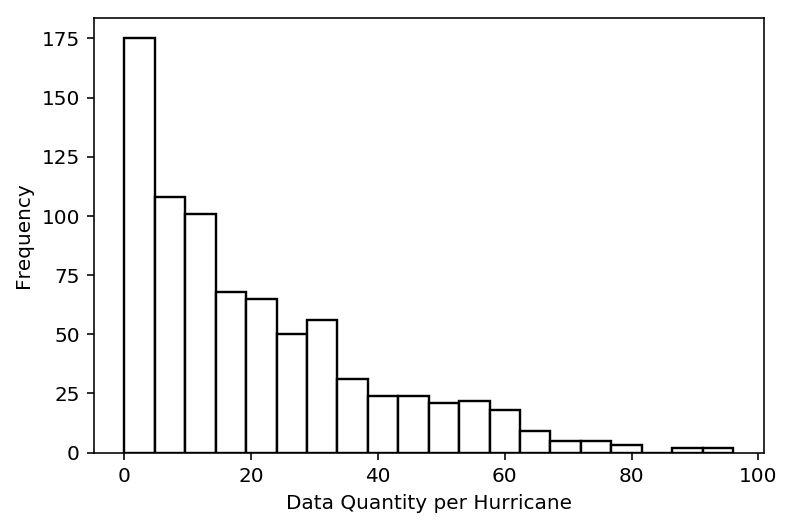

In [56]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

# Print the distribution of data quantity for all hurricanes
dist = hurricane_amount.plot.hist(bins=20, edgecolor='black', histtype='barstacked', color='white', legend=None, linewidth=1.2)
plt.xlabel("Data Quantity per Hurricane")
plt.ylabel("Frequency")

plt.savefig('data_quantity_distribution')
plt.show()

In [70]:
data.describe()

      Month  Day  Hour   Lat  Long  WindSpeed  Pressure      unique-key
6694      9   10    12  15.5 -38.0       25.0      1008  NADINE-2012-14
6695      9   10    18  15.6 -39.4       25.0      1007  NADINE-2012-14
6696      9   11     0  15.8 -40.8       25.0      1007  NADINE-2012-14
6697      9   11     6    16 -41.9       25.0      1007  NADINE-2012-14
6698      9   11    12  16.4 -42.8       30.0      1006  NADINE-2012-14
6699      9   11    18  16.9 -43.7       30.0      1006  NADINE-2012-14
6700      9   12     0  17.5 -44.8       35.0      1004  NADINE-2012-14
6701      9   12     6  18.1 -45.9       45.0      1001  NADINE-2012-14
6702      9   12    12  18.8 -47.1       50.0       997  NADINE-2012-14
6703      9   12    18  19.5 -48.3       55.0       994  NADINE-2012-14
6704      9   13     0  20.2 -49.5       60.0       990  NADINE-2012-14
6705      9   13     6    21 -50.6       60.0       990  NADINE-2012-14
6706      9   13    12    22 -51.7       60.0       990  NADINE-

In [71]:
cond = (hurricane_amount > 6) & (hurricane_amount < 60)
keys25 = []

for x in cond.index:
    if cond.loc[x][0]:
        keys25.append(keys[x][1])

word2keys = {}
for x in keys:
    word2keys[x[1]] = x[0]
    
data = data[data['unique-key'].isin(keys25)]
keys = list(enumerate(pd.unique(data['unique-key'])))
data.head()

,Month,Day,Hour,Lat,Long,WindSpeed,Pressure,unique-key
116,8,13,18,22.5,-93.5,30.0,1008,BERYL-2000-5
117,8,14,0,22.7,-93.8,30.0,1008,BERYL-2000-5
118,8,14,6,23.1,-94.6,35.0,1007,BERYL-2000-5
119,8,14,12,23.5,-95.4,40.0,1009,BERYL-2000-5
120,8,14,18,23.9,-96.3,45.0,1009,BERYL-2000-5


In [72]:
# Total amount of data tuples
total_data_count = len(data)
print(total_data_count)

# Total amount of hurricanes (again to double check if things were removed)
total_hurricane_count = len(pd.unique(data['unique-key']))
print(total_hurricane_count)

13131
539


### Data Preprocessing

From the dataset, we have latitude and longitude. It is easier for the neural network to learn from distance vectors since these values do not contain negative values (like latitude and longitude). To preprocess our data, we will calculate the angle of travel and distance between each given point and add that as new columns to our DataFrame. In addition, we will remove the outlier hurricanes, to get a more normal distribution to insert into the neural network.

In [60]:
from geopy.distance import great_circle as vc
import math as Math

# temp = data['Lat'].select_dtypes(include=['float64'])
# Lat has some rows with missing values?? check

y = np.zeros(total_hurricane_count)
data['distance'] = np.zeros(total_data_count)
data['direction'] = np.zeros(total_data_count)

# For all hurricanes
for x in range(0, total_hurricane_count):
    t = pd.DataFrame(data[data['unique-key'] == keys[x][1]], columns = data.keys()).reset_index(drop = False)
    dst = 0
    prev = (0,0)
    
    # For all latitude and longitude points of hurricane, calculate the angle of travel and distance
    for p in zip(t['Lat'], t['Long']):
        
        if prev == (0,0):
            prev = p
            continue 
        # Stores the distance into the DataFrame
        data.set_value(t[(t['Lat'] == p[0]) & (t['Long'] == p[1])]['index'].values[0], 'distance', vc(prev,p).miles)
        
        dLon = p[1] - prev[1];  
        temp = float(p[0]) # p[0] is a str?
        y_x = Math.sin(dLon) * Math.cos(temp);
        
        x_x = Math.cos(p[1]) * Math.sin(temp) - Math.sin(p[1]) * Math.cos(temp) * Math.cos(dLon);
        brng = Math.degrees(Math.atan2(y_x, x_x)) 
        if (brng < 0):
            brng+= 360;
        
        # Stores the angle of travel into the DataFrame
        data.set_value(t[(t['Lat'] == p[0]) & (t['Long'] == p[1])]['index'].values[0], 'direction', brng)
        dst += vc(prev,p).miles
        prev = p
    y[x] = dst

# Now contains the distance between all given latitude and longitude points
hurricane_distance = pd.DataFrame(y)

d:\anaconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:24: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
d:\anaconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:36: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [61]:
# Columns have been added
data.head()

,Month,Day,Hour,Lat,Long,WindSpeed,Pressure,unique-key,distance,direction
116,8,13,18,22.5,-93.5,30.0,1008,BERYL-2000-5,0.000000,0.000000
117,8,14,0,22.7,-93.8,30.0,1008,BERYL-2000-5,23.610733,140.567975
118,8,14,6,23.1,-94.6,35.0,1007,BERYL-2000-5,57.951317,161.351184
119,8,14,12,23.5,-95.4,40.0,1009,BERYL-2000-5,57.818260,174.302218
120,8,14,18,23.9,-96.3,45.0,1009,BERYL-2000-5,63.310039,337.250833


In [62]:
# Here we can see that the hurricane that traveled the least only traveled 65 miles, while the one that traveled the most traveled 8402 miles
hurricane_distance.describe()

,0
count,539.000000
mean,1898.071979
std,1484.196346
min,0.000000
25%,814.944359
50%,1630.781562
75%,2792.955542
max,6394.657177


In [63]:
# Print the hurricane key with the amount of data they contain
print ('Top 6 Hurricanes (in terms of distance traveled)')
for x in hurricane_distance.nlargest(6, 0).index:
    print (keys[x][1], "-", hurricane_distance.loc[x][0], "miles -", hurricane_amount.loc[x][0])
    
print(len(hurricane_distance[0]))
print(len(hurricane_amount[0]))
    
# Plotted the amount of hurricane distance traveled vs the amount of data they contain.
# corr = plt.scatter(hurricane_distance[0], hurricane_amount[0], color="black")
# plt.xlabel("Distance Traveled")
# plt.ylabel("Data Points recorded per Hurricane")

# plt.savefig('data_quantity_distribution')
# plt.show()

data.to_csv('checkpoint-dataframe.csv') # Save checkpoint

Top 6 Hurricanes (in terms of distance traveled)
KATE-2003-16 - 6394.657177015865 miles - 58.0
BERTHA-1996-2 - 6393.577053803421 miles - 51.0
RAFAEL-2012-17 - 6353.528847531551 miles - 56.0
BILL-2009-3 - 6238.175190303443 miles - 46.0
EARL-2010-7 - 6199.014179688364 miles - 55.0
ISAAC-2000-13 - 6158.663246942403 miles - 52.0
539
789


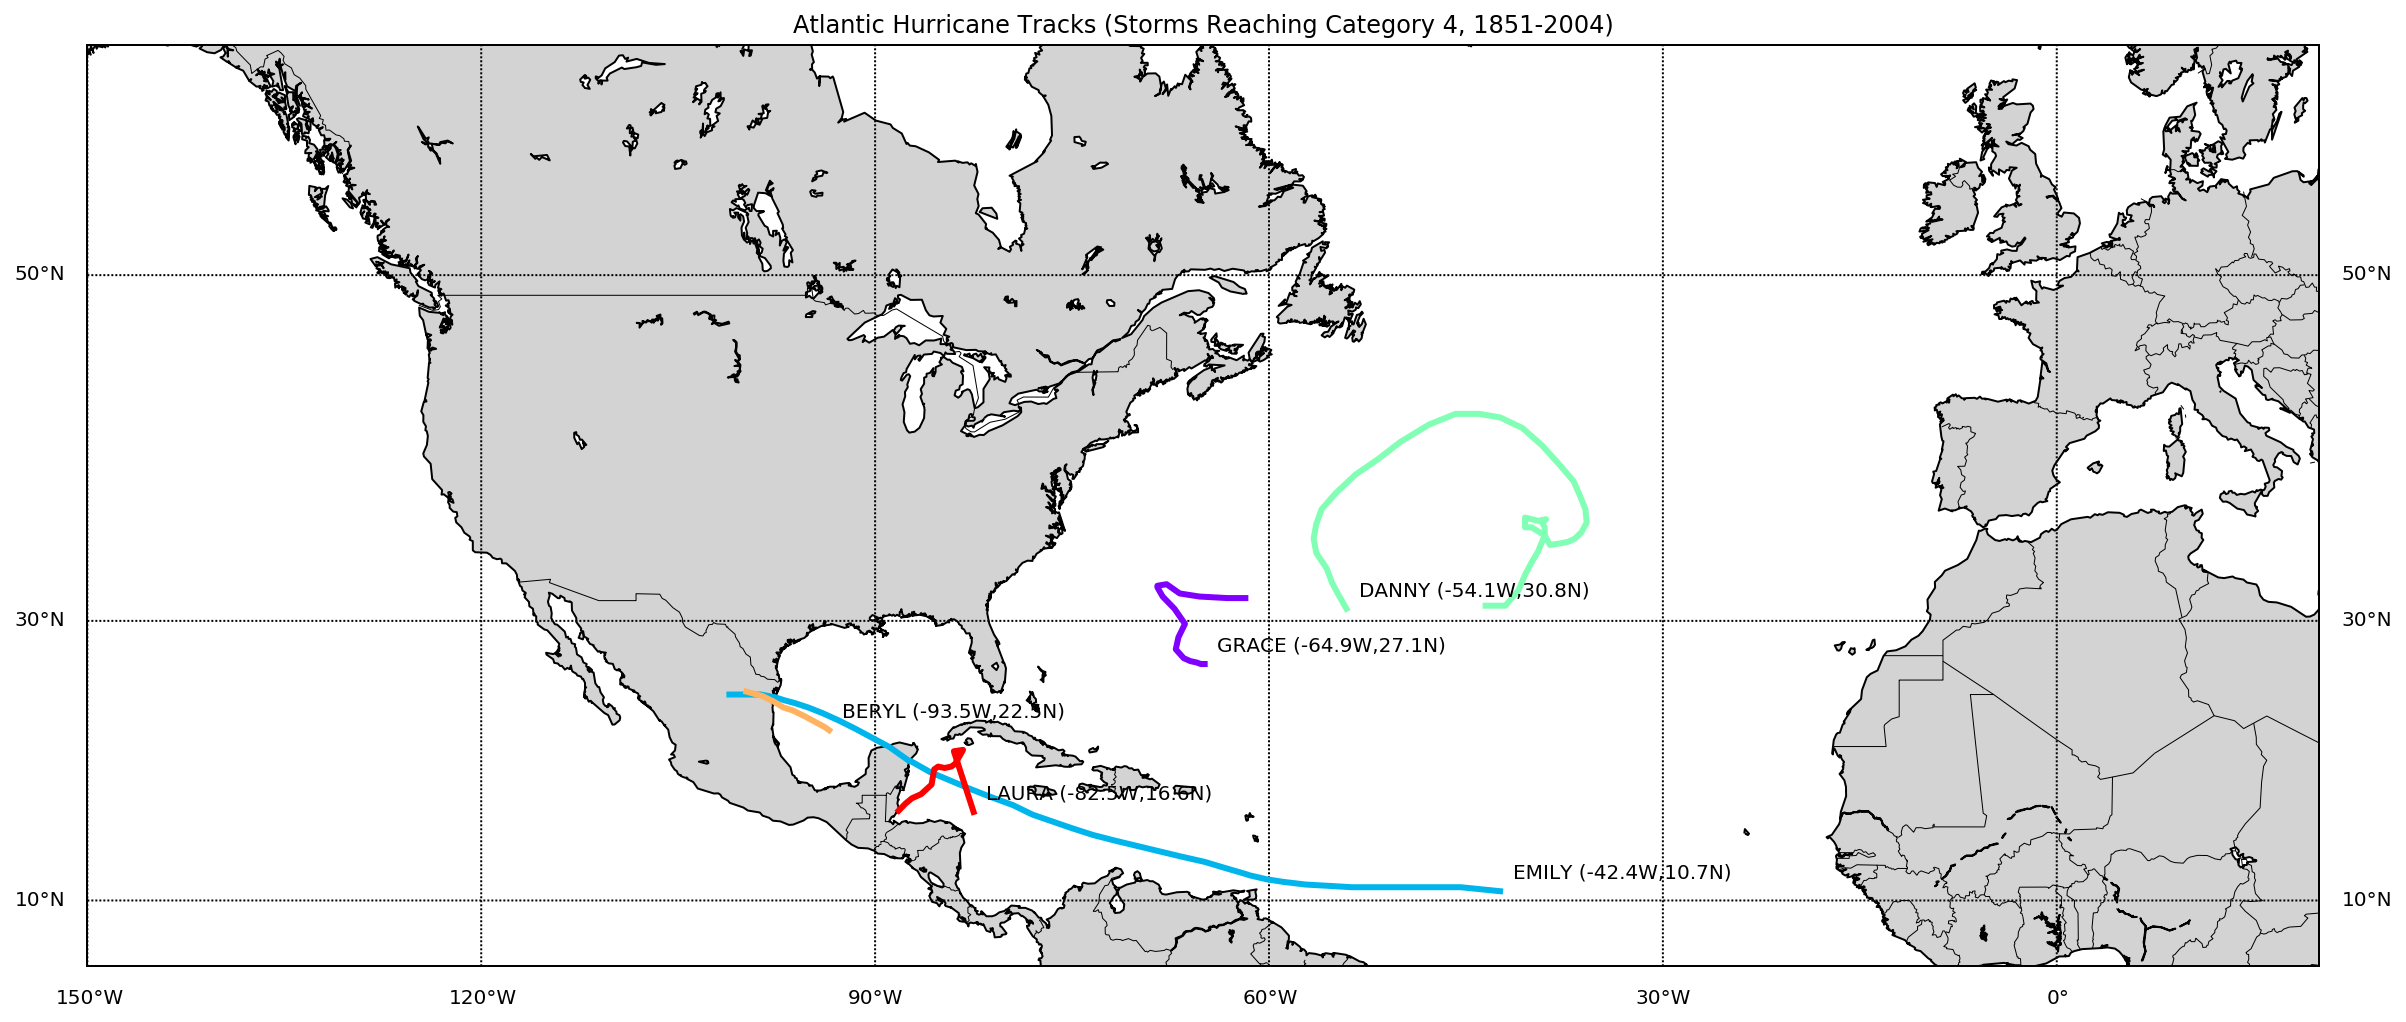

In [94]:
from mpl_toolkits.basemap import Basemap
import matplotlib.cm as cm

n_large = 5
# Graph the trajectories of the longest hurricanes (the ones that traveled the most)
data = pd.read_csv('checkpoint-dataframe.csv', index_col=0, header=0)
plt.figure(figsize=(20,10))
m = Basemap(llcrnrlon=-150.,llcrnrlat=5.,urcrnrlon=20.,urcrnrlat=60.,\
            rsphere=(6378137.00,6356752.3142),\
            resolution='l',projection='merc',\
            lat_0=40.,lon_0=-20.,lat_ts=20.)
m.drawcoastlines()
m.drawcountries()
m.drawmapboundary(fill_color='white')
m.fillcontinents(color='#D3D3D3')
m.drawparallels(np.arange(10,90,20),labels=[1,1,0,1])
m.drawmeridians(np.arange(-180,180,30),labels=[1,1,0,1])

colors = 'black'#iter(cm.rainbow(np.linspace(0, 1, n_large)))
for x in hurricane_amount.nlargest(n_large, 0).index:
    
    largest_hurr = data[data['unique-key'] == keys[x][1]]
#     print(largest_hurr)
#     data[data['unique-key'] == keys[x][1]].plot(x='Lat', y='Long')
    lat = largest_hurr['Lat'].values
    long = largest_hurr['Long'].values
    #print(lat,long)
    xpt, ypt = m(long, lat)
    plt.text(xpt[0]+100000,ypt[0]+100000,  '%s (%5.1fW,%3.1fN)' % (keys[x][1].split('-')[0],long[0],lat[0]))
    #print(x,y)
    m.plot(xpt, ypt, linewidth=3, color=#next(colors))


plt.title('Atlantic Hurricane Tracks (Storms Reaching Category 4, 1851-2004)')
plt.show()

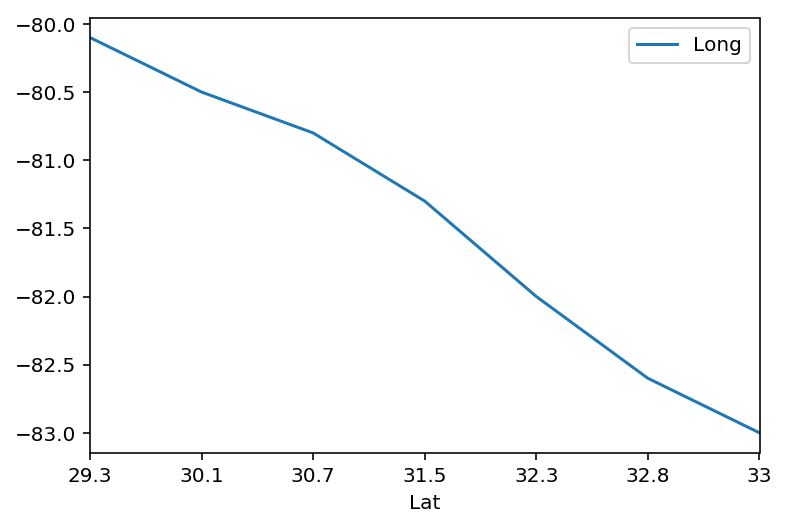

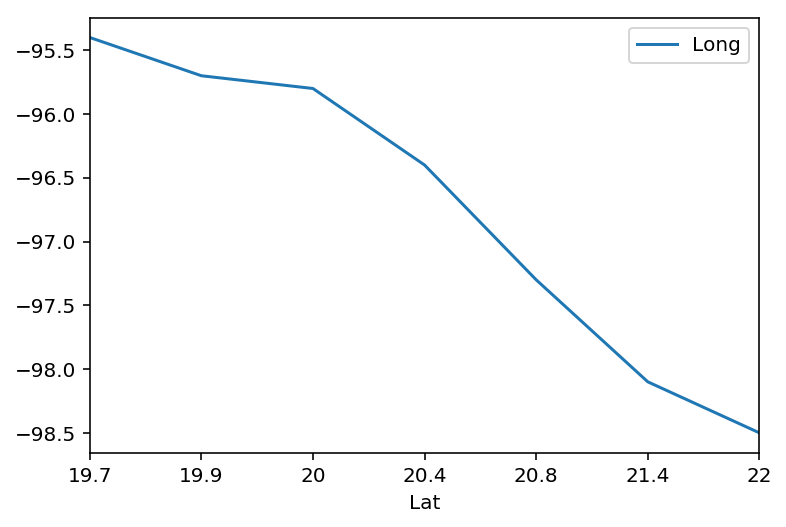

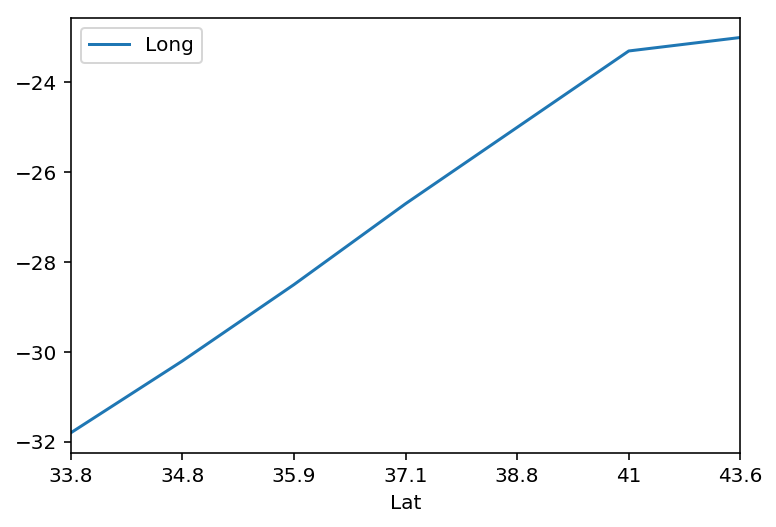

In [43]:
# Graph the trajectories of the shortest hurricanes (the ones that traveled the least)
for x in hurricane_amount.nsmallest(3, 0).index:
    data[data['unique-key'] == keys[x][1]].plot(x='Lat', y='Long')

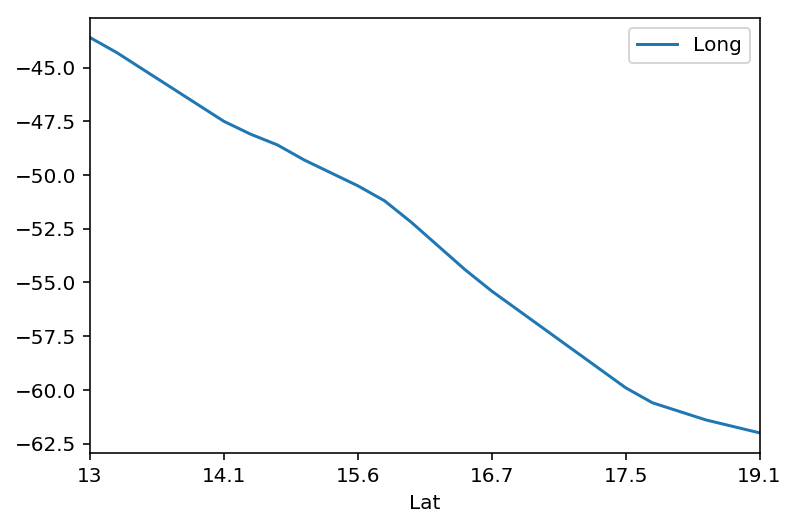

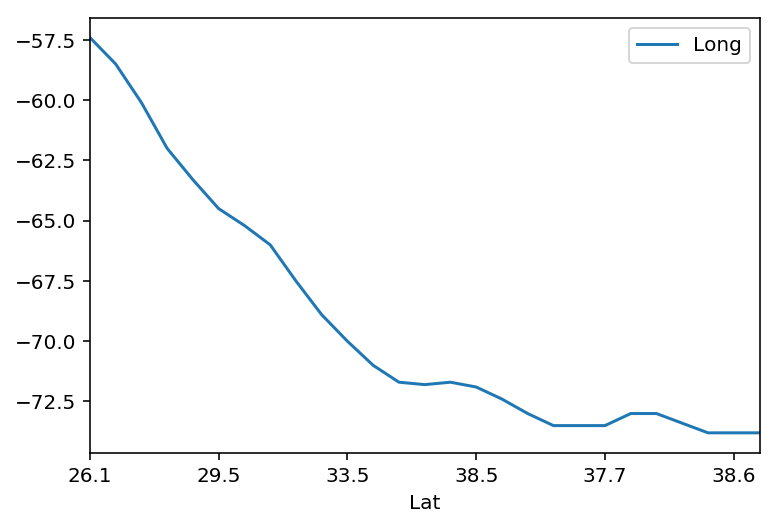

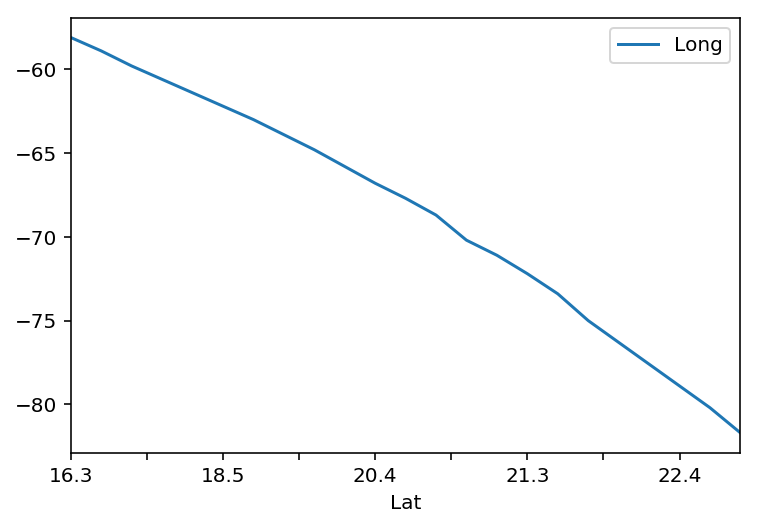

In [93]:
# Graph the trajectories of 3 random hurricanes 
for x in np.random.choice(170, 3):
     data[data['unique-key'] == keys[x][1]].plot(x='Lat', y='Long') 

In [94]:
# We are removing some outliers that contain too little or too much information to keep a more normal distribution.
cond = (hurricane_amount > 13) & (hurricane_amount < 60)
keys25 = []

for x in cond.index:
    if cond.loc[x][0]:
        keys25.append(keys[x][1])

word2keys = {}
for x in keys:
    word2keys[x[1]] = x[0]
    
df = data[data['unique-key'].isin(keys25)]
df.head()

,Month,Day,Hour,Lat,Long,WindSpeed,Pressure,unique-key,distance,direction
134,8,19,18,12,-44.5,30.0,1010,DEBBY-2000-7,0.0,0.0
135,8,20,0,12.6,-45.3,30.0,1010,DEBBY-2000-7,0.0,0.0
136,8,20,6,13.3,-46.8,35.0,1009,DEBBY-2000-7,0.0,0.0
137,8,20,12,14,-48.8,40.0,1008,DEBBY-2000-7,0.0,0.0
138,8,20,18,14.7,-50.6,45.0,1007,DEBBY-2000-7,0.0,0.0


In [95]:
# Total amount of hurricanes we have now 
print(len(pd.unique(df['unique-key'])))

384


In [23]:
# Description of our new dataset 
df.describe()

,Month,Day,Hour,Lat,Long,WindSpeed,Pressure,distance,direction
count,163.000000,163.000000,163.000000,163.000000,163.000000,163.000000,0.0,163.000000,163.000000
mean,16.134969,9.233129,6.147239,-77.960123,46.595092,48.036810,NaN,2995.851683,133.543951
std,8.950836,6.716086,3.580181,13.011242,38.683208,212.132759,NaN,3867.035662,111.531743
min,1.000000,0.000000,1.000000,-98.700000,-99.000000,0.000000,NaN,34.556395,-0.000000
25%,8.500000,5.000000,3.000000,-88.000000,25.000000,0.000000,NaN,656.571513,16.264462
50%,15.000000,12.000000,6.000000,-78.600000,40.000000,0.000000,NaN,1485.286514,144.802616
75%,23.500000,12.000000,8.000000,-72.150000,67.500000,0.000000,NaN,2625.056225,195.700802
max,31.000000,21.000000,19.000000,-29.700000,140.000000,1008.000000,NaN,11828.362901,352.935296


In [124]:
# Same thing we did before to view the data but now with the reduced dataset 
keys = list(enumerate(pd.unique(df['unique-key'])))

y = np.zeros((116))
for x in range(0,116):
    y[x] = len(pd.DataFrame(df[df['unique-key'] == keys[x][1]], columns = df.keys()).reset_index(drop = True))

hurricane_amount = pd.DataFrame(y)

In [125]:
# Now we can see that we have at least 14 rows of information per hurricane and at most 59.
hurricane_amount.describe()

,0
count,116.000000
mean,32.543103
std,12.800402
min,14.000000
25%,23.000000
50%,29.000000
75%,43.250000
max,59.000000


Top 6 Hurricanes (in terms of data quantity)
DENNIS-2005-4 - 59.0
ISABEL-2003-13 - 58.0
KATE-2003-16 - 58.0
ALLISON-2001-1 - 57.0
LILI-2002-13 - 57.0
GORDON-2006-8 - 57.0


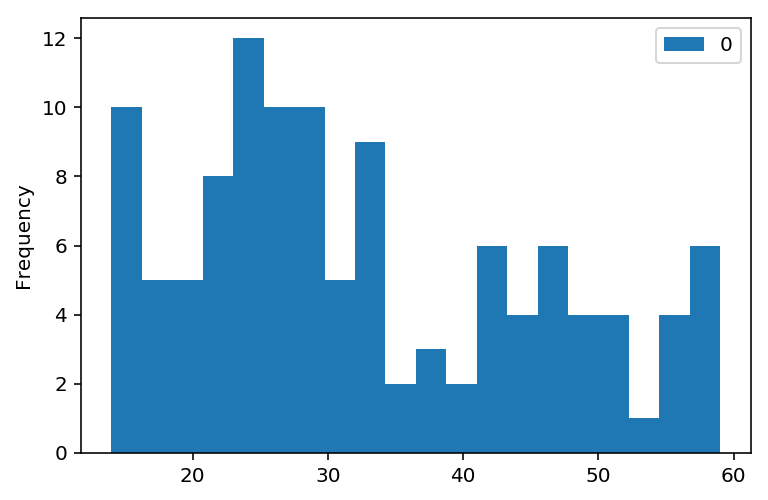

In [126]:
print ('Top 6 Hurricanes (in terms of data quantity)')
for x in hurricane_amount.nlargest(6, 0).index:
    print (keys[x][1], "-", hurricane_amount.loc[x][0])
    
hurricane_amount.plot.hist(bins=20)
plt.show()

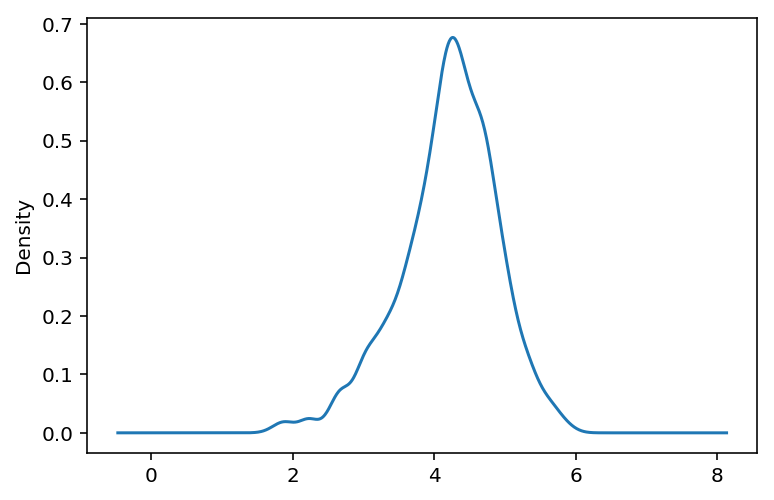

In [127]:
# Distribution of distance traveled in a 6 hour time interval for all hurricanes
dist = df[df['distance'] > 0]
dist = np.log(dist['distance'])
ser = pd.Series(dist)
ser.plot.kde()

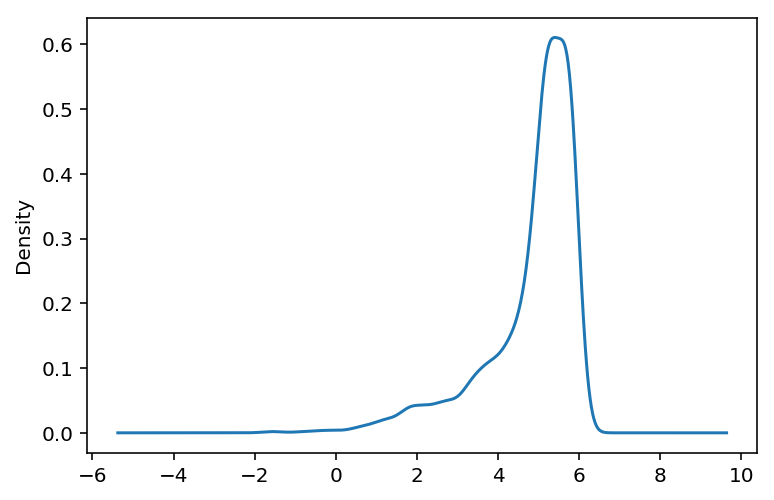

In [128]:
# Distribution of angle traveled in a 6 hour time interval for all hurricanes
direc = df[df['direction'] > 0]
direc = np.log(direc['direction'])
ser = pd.Series(direc)
ser.plot.kde()

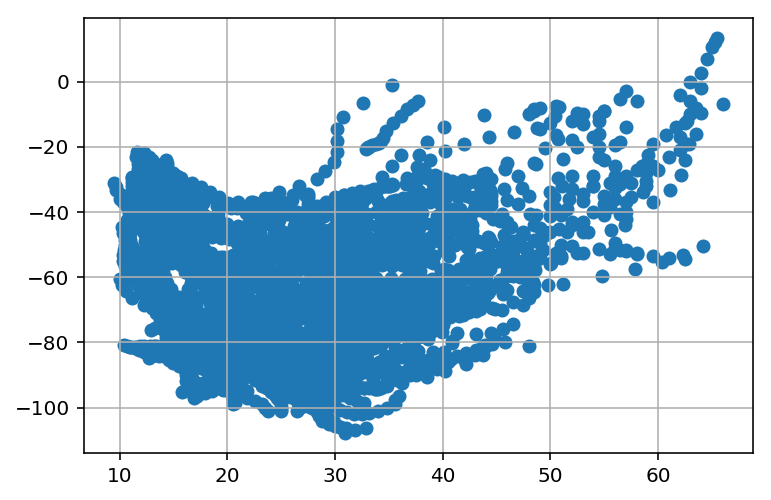

In [129]:
corr = plt.scatter(df['Lat'], df['Long'])
plt.grid()
plt.show()

In [130]:
# Assigning each point to a specific location in the grid. 
# For example, we will learn how a hurricane in quadrant 2 with move.
df['gridID'] = np.zeros(3775)

/Users/sheilaalemany/anaconda/envs/SparkDevAI/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [131]:
# These variable are hyperparameters
lat_interval = 20
long_interval = 40

df['gridID'] = (df['Lat'] - 9.500) / lat_interval + ( (df['Long'] + 107.700) * 6) / long_interval
df['gridID'] = round(df['gridID'])
    
df.head()

/Users/sheilaalemany/anaconda/envs/SparkDevAI/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/sheilaalemany/anaconda/envs/SparkDevAI/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Month,Day,Hour,Lat,Long,WindSpeed,Pressure,unique-key,distance,direction,gridID
134,8,19,18,12.0,-44.5,30,1010,DEBBY-2000-7,0.000000,0.000000,10.0
135,8,20,0,12.6,-45.3,30,1010,DEBBY-2000-7,68.101484,313.591887,10.0
136,8,20,6,13.3,-46.8,35,1009,DEBBY-2000-7,112.017434,230.165829,9.0
137,8,20,12,14.0,-48.8,40,1008,DEBBY-2000-7,142.766983,322.273966,9.0
138,8,20,18,14.7,-50.6,45,1007,DEBBY-2000-7,129.867994,31.781920,9.0


In [132]:
df.to_csv('checkpoint-dataframe.csv') # Save the dataframe to csv for checkpoint

### Build the Model

In [19]:
# Load the preprocessed data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('checkpoint-dataframe.csv', index_col=0) 

In [20]:
df.head() # Check loaded data

,Month,Day,Hour,Lat,Long,WindSpeed,Pressure,unique-key,distance,direction,gridID
134,8,19,18,12.0,-44.5,30,1010,DEBBY-2000-7,0.000000,0.000000,10.0
135,8,20,0,12.6,-45.3,30,1010,DEBBY-2000-7,68.101484,313.591887,10.0
136,8,20,6,13.3,-46.8,35,1009,DEBBY-2000-7,112.017434,230.165829,9.0
137,8,20,12,14.0,-48.8,40,1008,DEBBY-2000-7,142.766983,322.273966,9.0
138,8,20,18,14.7,-50.6,45,1007,DEBBY-2000-7,129.867994,31.781920,9.0


In [21]:
df.drop(['Month', 'Day', 'Hour', 'Lat', 'Long', 'unique-key'], axis = 1, inplace = True)
temp_df = df

temp_df = temp_df[temp_df['distance'] > 0]
temp_df['distance'] = np.log(temp_df['distance'])

temp_df = temp_df[temp_df['direction'] > 0]
temp_df['direction'] = np.log(temp_df['direction'])

temp_df.head()

/Users/sheilaalemany/anaconda/envs/SparkDevAI/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,WindSpeed,Pressure,distance,direction,gridID
135,30,1010,4.220999,5.748092,10.0
136,35,1009,4.718655,5.438800,9.0
137,40,1008,4.961214,5.775402,9.0
138,45,1007,4.866519,3.458898,9.0
139,55,1006,4.643692,4.644905,9.0


In [22]:
max(temp_df['gridID']) # Total grid spots

21.0

In [23]:
from sklearn.preprocessing import MinMaxScaler

# Normalize the values to predict them more easily in our model
scaler = MinMaxScaler(feature_range=(0, 1))
temp_df = pd.DataFrame(scaler.fit_transform(temp_df), columns=['WindSpeed', 'Pressure', 'Distance', 'Direction', 'gridID'])
temp_df.head()

,WindSpeed,Pressure,Distance,Direction,gridID
0,0.133333,0.901408,0.591214,0.981638,0.45
1,0.166667,0.894366,0.706921,0.940433,0.40
2,0.200000,0.887324,0.763317,0.985277,0.40
3,0.233333,0.880282,0.741300,0.676661,0.40
4,0.300000,0.873239,0.689492,0.834667,0.40


In [24]:
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.as_matrix() 
    sequence_length = seq_len + 1 # Because index starts at 0
    result = []
    
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    result = np.array(result)
    row = len(result) * 0.85 # Amount of data to train on    
    train = result[:int(row), :]
    x_train = train[:, :-1]
    y_train = train[:, -1][:,-1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]

In [25]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
import math, time

def build_model(layers):
    model = Sequential()

    for x in range(0,5):
        model.add(LSTM(input_dim=layers[0], output_dim=layers[1], return_sequences=True))
        model.add(Dropout(0.2))

    model.add(LSTM(layers[2], return_sequences=False)) 
    model.add(Dropout(0.2))

    model.add(Dense(output_dim=layers[2]))
    model.add(Activation("relu"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop",metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

### Train the Model

In [26]:
window = 14 # Another hyperparameter
X_train, y_train, X_test, y_test = load_data(temp_df[::-1], window)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (3005, 14, 5)
y_train (3005,)
X_test (531, 14, 5)
y_test (531,)


In [27]:
model = build_model([5, window, 1])

/Users/sheilaalemany/anaconda/envs/SparkDevAI/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # Remove the CWD from sys.path while we load stuff.
/Users/sheilaalemany/anaconda/envs/SparkDevAI/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 5), units=14)`
  # Remove the CWD from sys.path while we load stuff.


Compilation Time :  0.02554607391357422


/Users/sheilaalemany/anaconda/envs/SparkDevAI/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
  app.launch_new_instance()


In [28]:
model.fit(X_train, y_train, batch_size=512, epochs=100, validation_split=0.1, verbose=0)

In [29]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

Train Score: 0.01 MSE (0.09 RMSE)
Test Score: 0.01 MSE (0.08 RMSE)


### Predicting Hurricane Trajectory

In [30]:
pred = model.predict(X_train)

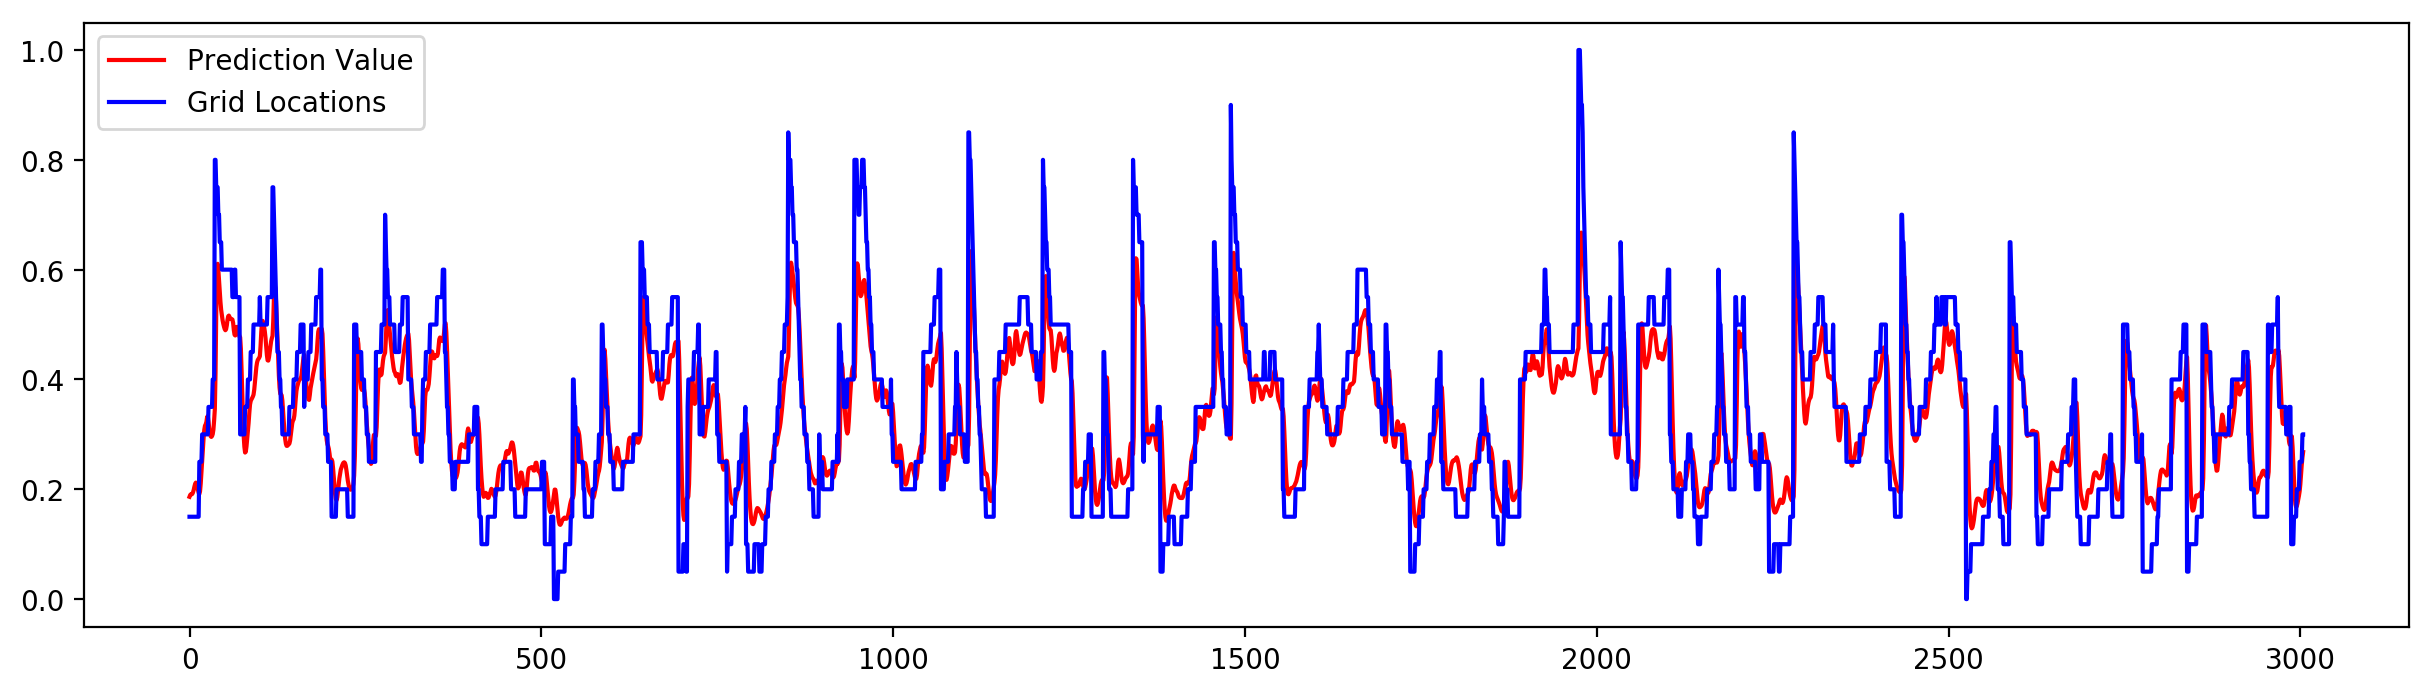

In [33]:
plt.figure(figsize=(15, 4), dpi=100)
plt.plot(pred, color='red', label='Prediction Grid Locations')
plt.plot(y_train, color='blue', label='Real Grid Locations')
plt.legend(loc='upper left')

plt.savefig('grid_accuracy.png')
plt.show()

In [44]:
# import plotly.plotly as py
import plotly as py
import plotly.graph_objs as go

key = 'IDA-2009-11'
df =  pd.read_csv('checkpoint-dataframe.csv', index_col=0)

points = df[df['unique-key'] == key]
plots = []
real = dict(
    type = 'scattergeo',
    lat = points['Lat'],
    lon = points['Long'],
    mode = 'lines',
    line = dict(
        width = 4,
        color = 'blue',
    ),
)
plots.append(real)

layout = dict(
        title = 'Hurricane' + key,
        showlegend = False,         
        geo = dict(
            resolution = 50,
            showland = True,
            showlakes = True,
            landcolor = 'rgb(204, 204, 204)',
            countrycolor = 'rgb(204, 204, 204)',
            lakecolor = 'rgb(255, 255, 255)',
            projection = dict( type="equirectangular" ),
            coastlinewidth = 2,
            lataxis = dict(
                range = [ 9.5, 66 ],
                showgrid = True,
                tickmode = "linear",
                dtick = 10
            ),
            lonaxis = dict(
                range = [ -107.7, 13.5 ],
                showgrid = True,
                tickmode = "linear",
                dtick = 20
            ),
        )
    )
    
fig = dict( data=plots, layout=layout )
py.offline.plot( fig, validate=False, filename='d3-great-circle' )

# py.image.save_as(fig, filename='a-simple-plot.png')
# Image('a-simple-plot.png')

/Users/sheilaalemany/anaconda/envs/SparkDevAI/lib/python3.6/site-packages/plotly/offline/offline.py:459: UserWarning:

Your filename `d3-great-circle` didn't end with .html. Adding .html to the end of your file.



'file:///Users/sheilaalemany/hurricane-rnn/d3-great-circle.html'